# Prediction by Support Vector Machine

In this notebook, the use of an SVM to predict the digits is investigated. First, all the imports and the loading of the data, as usual. The data is then normalized before continuation.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
X = np.loadtxt('data.txt', skiprows=0)
X = normalize(X)
# possible digits
digits = np.array([0,1,2,3,4,5,6,7,8,9])

# create target vector by repeating digits 200 times
y = np.repeat(digits, 200, axis=0)



## Basic SVM Algorithm(s)

Based on SKLearn Docs: https://scikit-learn.org/stable/modules/svm.html

Three different kernels were tested in a k-Fold Cross-Validation Scheme with k=10, a linear kernel(which basically is a polynomial with a degree of 1), a polynomial with 3 df and an RBF Kernel. The Polynomial seems best, all other kernels did well, but not this well. The accuracy generally already is very high, but attempts will be made to improve upon it.

In [3]:
# Will be explained in next part
def digitwise_accuracy(pred_y, test_y):
    prederrorstuff = []
    for i in range(10):
        curr_acc = []
        for j in range(len(pred_y)):
            if pred_y[j] == i:
                if pred_y[j] == test_y[j]:
                    curr_acc.append(1)
                else:
                    curr_acc.append(0)
        prederrorstuff.append(np.mean(curr_acc))

    return prederrorstuff

Mean k-Fold accuracy using Linear Kernel: 0.9734999999999999
Mean k-Fold accuracy using Polynomial df=3 Kernel: 0.9829999999999999
Mean k-Fold accuracy using RBF Kernel: 0.9795


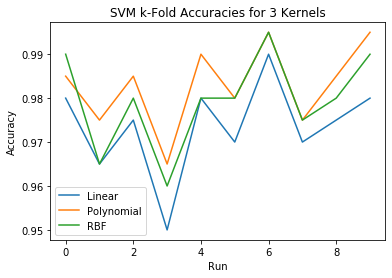

In [4]:
from sklearn import svm
from sklearn.metrics import accuracy_score

# Lists to hold accuracy tables for kernels
kf_acc_lin = []
kf_acc_poly = []
kf_acc_rbf = []

# List to hold digitwise accuracies
dw_acc_lin = []
dw_acc_poly = []
dw_acc_rbf = []

# kFold based on example in https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
kf = KFold(n_splits=10, shuffle=True, random_state=2002)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Linear Kernel
    svc_lin = svm.SVC(kernel="linear", degree=1, decision_function_shape="ovo")
    # Polynomial Kernel
    svc_poly= svm.SVC(kernel="poly", degree=3, decision_function_shape="ovo")
    # RBF Kernel
    svc_rbf = svm.SVC(kernel="rbf", degree=3, decision_function_shape="ovo")
    
    # Fitting Process
    svc_lin.fit(X_train, y_train)
    svc_poly.fit(X_train, y_train)
    svc_rbf.fit(X_train, y_train)
    
    # Prediction Process
    y_pred_lin = svc_lin.predict(X_test)
    y_pred_poly = svc_poly.predict(X_test)
    y_pred_rbf = svc_rbf.predict(X_test)
    
    # Append Accuracies to List
    kf_acc_lin.append(accuracy_score(y_test, y_pred_lin))
    kf_acc_poly.append(accuracy_score(y_test, y_pred_poly))
    kf_acc_rbf.append(accuracy_score(y_test, y_pred_rbf))
    
    # Append Digitwise accuracies
    dw_acc_lin.append(digitwise_accuracy(y_pred_lin, y_test))
    dw_acc_poly.append(digitwise_accuracy(y_pred_poly, y_test))
    dw_acc_rbf.append(digitwise_accuracy(y_pred_rbf, y_test))
    
print("Mean k-Fold accuracy using Linear Kernel: " + str(np.mean(kf_acc_lin)))
print("Mean k-Fold accuracy using Polynomial df=3 Kernel: " + str(np.mean(kf_acc_poly)))
print("Mean k-Fold accuracy using RBF Kernel: " + str(np.mean(kf_acc_rbf)))

plt.plot(kf_acc_lin, label="Linear")
plt.plot(kf_acc_poly, label="Polynomial")
plt.plot(kf_acc_rbf, label="RBF")
plt.title("SVM k-Fold Accuracies for 3 Kernels")
plt.xlabel("Run")
plt.ylabel("Accuracy")
plt.legend()

## Investigating Digitwise Accuracies

With the following very inefficient code, the "digitwise accuracy" will be investigated. Basically, the function "digitwise_accuracy" checks the probability of a prediction on a certain digit being correct. Basically the question: If model "s" outputs "5", how likely is it, that this is accurate. These digitwise accuracies are ultimately retrieved per model, investigating whether the combination of different models which are better at predicting different digits, might improve accuracies.

As it turns out, there are slight differences justifying the attempt to combine the judgment of multiple SVMs using different kernels, but generally the trend for all 3 kernels is the same. It turns out, however, that SVM generally seems to struggle with some digits (like "1", "3", "5") more than with others. As a consequence, combining the judgment of the SVM with the judgment of a different model like a random forest seems appropriate. An alternative reason regarding differences in accuracy between digits might be that it is generally more noisy, however, in which case a different model might struggle on the same digits.

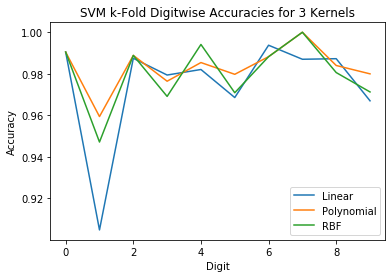

In [5]:
dw_mean_lin = []
dw_mean_poly = []
dw_mean_rbf = []

for i in range(10):
    dw_temp_lin = []
    dw_temp_poly = []
    dw_temp_rbf = []
    for j in range(10):
        dw_temp_lin.append(dw_acc_lin[j][i])
        dw_temp_poly.append(dw_acc_poly[j][i])
        dw_temp_rbf.append(dw_acc_rbf[j][i])
    dw_mean_lin.append(np.mean(dw_temp_lin))
    dw_mean_poly.append(np.mean(dw_temp_poly))
    dw_mean_rbf.append(np.mean(dw_temp_rbf))

plt.plot(dw_mean_lin, label="Linear")
plt.plot(dw_mean_poly, label="Polynomial")
plt.plot(dw_mean_rbf, label="RBF")
plt.title("SVM k-Fold Digitwise Accuracies for 3 Kernels")
plt.xlabel("Digit")
plt.ylabel("Accuracy")
plt.legend()

## Combining 2 SVMs with Polynomial and RBF-Kernel

The combined predictor uses one stage more. The training data set in the 10-fold cross-validation is separated in equally large training and validation sets. The Polynomial and RBF-based SVMs are then "tested", or "validated", on the validation set, retrieving their "digitwise accuracy", as defined before. The combined predictor (and the two SVMs for comparison purposes) is then tested on the test set. For each item, the predictions of both SVMs are compared, in that the one is chosen, which has the higher digit-accuracy for the digit it has predicted. In case of a tie, the decision of the polynomial is always preferred, as it performed better overall. After looping over all items, the predictions are compared with the labels.

It turns out that the combined predictor performs slightly worse than the SVM with polynomial kernel. While it is better for some digits, it is worse for others. The polynomial one therefore can be considered preferrable, but differences are negligible.

In [6]:
def combined_predictor(predictions, pred_accuracies):
    combined_predictions = []
    combined_pred_choice = []
    for i in range(len(predictions[0])):
        curr_pred = 0
        curr_acc = 0
        curr_mod = 0
        
        for j in range(len(pred_accuracies)):
            new_pred = predictions[j][i]
            new_acc = pred_accuracies[j][new_pred]
            if new_acc > curr_acc:
                curr_pred = new_pred
                curr_acc = new_acc
                curr_mod = j
                
        combined_predictions.append(curr_pred)
        combined_pred_choice.append(curr_mod)
        
    return combined_predictions

Mean k-Fold accuracy using Combined Kernel: 0.9764999999999999
Mean k-Fold accuracy using Polynomial df=3 Kernel: 0.9779999999999998
Mean k-Fold accuracy using RBF Kernel: 0.9749999999999999


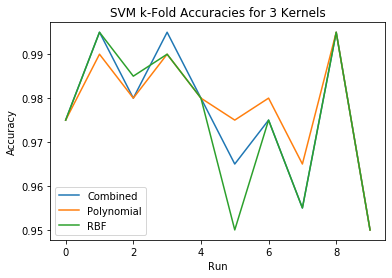

In [11]:
# Lists to hold accuracy tables for kernels
kf_acc_comb = []
kf_acc_poly = []
kf_acc_rbf = []

# List to hold digitwise accuracies
dw_acc_comb = []
dw_acc_poly = []
dw_acc_rbf = []

# kFold based on example in https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
kf = KFold(n_splits=10, shuffle=True, random_state=12345)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Separate training into train and validation set.
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state = 67890)
    
    # Polynomial Kernel
    svc_poly= svm.SVC(kernel="poly", degree=3, decision_function_shape="ovo")
    # RBF Kernel
    svc_rbf = svm.SVC(kernel="rbf", degree=3, decision_function_shape="ovo")
    
    # Fitting Process
    svc_poly.fit(X_train, y_train)
    svc_rbf.fit(X_train, y_train)
    
    # Validation Process
    y_val_pred_poly = svc_poly.predict(X_val)
    y_val_pred_rbf = svc_rbf.predict(X_val)
    
    # Testing
    y_pred_poly = svc_poly.predict(X_test)
    y_pred_rbf = svc_rbf.predict(X_test)
    y_pred_comb = combined_predictor([list(y_pred_poly), list(y_pred_rbf)], [digitwise_accuracy(y_val_pred_poly, y_val), digitwise_accuracy(y_val_pred_rbf, y_val)])
    
    # Append Accuracies to List
    kf_acc_comb.append(accuracy_score(y_test, y_pred_comb))
    kf_acc_poly.append(accuracy_score(y_test, y_pred_poly))
    kf_acc_rbf.append(accuracy_score(y_test, y_pred_rbf))
    
    # Append Digitwise accuracies
    dw_acc_comb.append(digitwise_accuracy(y_pred_comb, y_test))
    dw_acc_poly.append(digitwise_accuracy(y_pred_poly, y_test))
    dw_acc_rbf.append(digitwise_accuracy(y_pred_rbf, y_test))
    
print("Mean k-Fold accuracy using Combined Kernel: " + str(np.mean(kf_acc_comb)))
print("Mean k-Fold accuracy using Polynomial df=3 Kernel: " + str(np.mean(kf_acc_poly)))
print("Mean k-Fold accuracy using RBF Kernel: " + str(np.mean(kf_acc_rbf)))

plt.plot(kf_acc_comb, label="Combined")
plt.plot(kf_acc_poly, label="Polynomial")
plt.plot(kf_acc_rbf, label="RBF")
plt.title("SVM k-Fold Accuracies for 3 Kernels")
plt.xlabel("Run")
plt.ylabel("Accuracy")
plt.legend()